In [1]:
import warnings
warnings.simplefilter("ignore", UserWarning)

from numpy import *
from matplotlib.pyplot import *
from skimage import io
from scipy.ndimage.morphology import binary_closing,binary_opening

import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
import matplotlib.patches as mpatches

from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb

from sys import path
from os.path import abspath
path.append(abspath('../..'))
from crnpy.colors import cyan,yellow

from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import BayesianRidge
from sklearn.pipeline import Pipeline

from glob import glob
from os import system
    
# basis function
def sigmoid(x) :
    return 1.0/(1.0+exp(-x))

# feature vector
def features(x,degree=3) :
    x = squeeze(x)
    fx = [ sigmoid(sigma*(x-mu)) for mu in linspace(0.25,.75,num=degree) for sigma in [-20,20] ]
    return stack(fx,axis=-1)


def fit(data,threshold = 25000,t_final=24,x_width=1.0) :
    
    # create coordinate meshes
    n_frames,height,width,n_channels = data.shape
    x,t = linspace(0,x_width,num=width),linspace(0,t_final,num=n_frames)

    xx,tt = meshgrid(x,t)
    X,Y = meshgrid(x,linspace(0,1,num=height))
    cfp,yfp,rfp = 0,1,2
    
    # intensity normalisation
    data /= nanmax(data,axis=(0,1,2))

    # setting values outside grid squares to nan
    mask = data[-1,...,rfp] < 0.5
    mask = stack([[ mask for _ in range(n_frames) ] for _ in range(n_channels) ],axis=-1)
    data[mask] = NaN
    
    # create regressors
    yfp_predictor = Pipeline([("feature-map", FunctionTransformer(features)), ("regressor", BayesianRidge() )])
    cfp_predictor = Pipeline([("feature-map", FunctionTransformer(features)), ("regressor", BayesianRidge() )])

    # fit both channels for each timepoint
    yfp_predictions,cfp_predictions = [],[]
    for t in range(n_frames):

        input = data[t,...,yfp]
        yfp_predictor.fit(X[~isnan(input)].reshape(-1,),input[~isnan(input)].reshape(-1,))
        yfp_predictions += [yfp_predictor.predict(x.reshape(-1,))]

        input = data[t,...,cfp]
        cfp_predictor.fit(X[~isnan(input)].reshape(-1,),input[~isnan(input)].reshape(-1,))
        cfp_predictions += [cfp_predictor.predict(x.reshape(-1,))]

    predictions = stack([yfp_predictions,cfp_predictions],axis=-1)
    return xx,tt,predictions,yfp_predictor,cfp_predictor

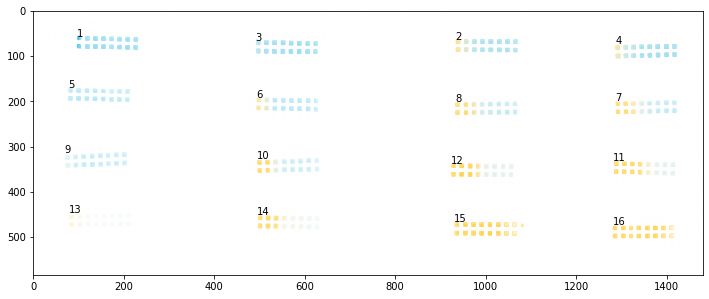

In [2]:
hyperstack = io.imread('./20200108 exrep 10uM IPTG_small.tif')
cfp,yfp,rfp = 0,1,2

gridmask = hyperstack[-1,:,:,rfp] > mean(hyperstack[-2,:,:,rfp])
gridmask = binary_closing(binary_opening(gridmask,structure=ones((10,10))),structure=ones((10,10)))
image_regions = label(clear_border(gridmask))

figure(figsize=(12,12))
imshow(hyperstack[-1,:,:,yfp],cmap='yellow')
imshow(hyperstack[-1,:,:,cfp],cmap='cyan')

for region in regionprops(image_regions):
    if region.area >= 100:
        
        minr, minc, maxr, maxc = region.bbox
        text(minc,minr, str(region.label))

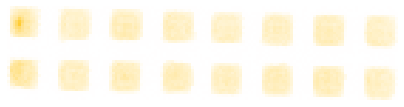

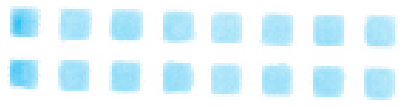

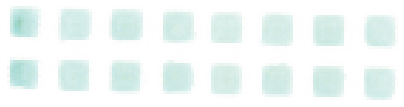

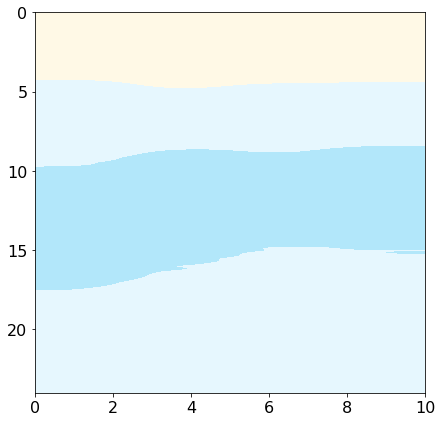

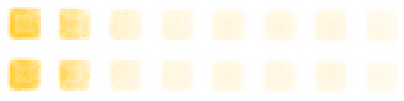

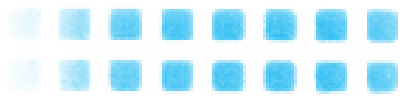

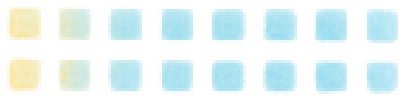

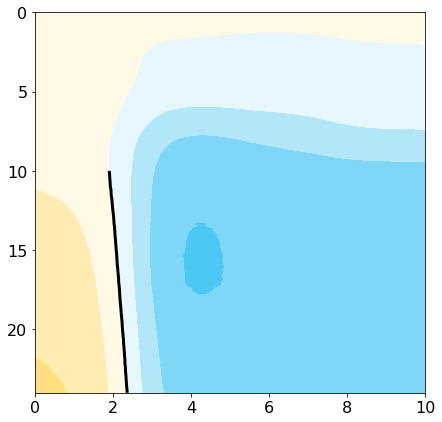

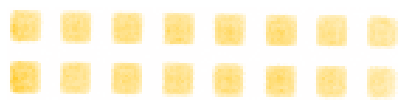

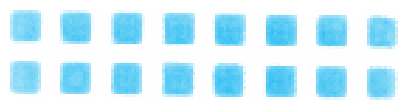

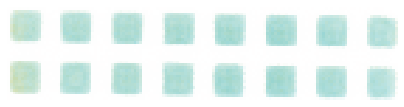

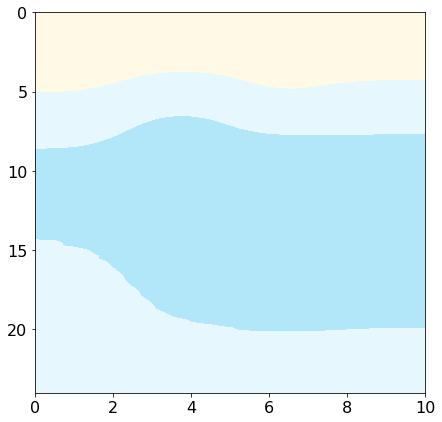

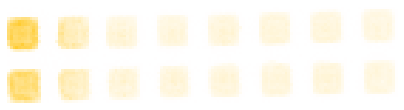

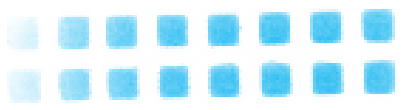

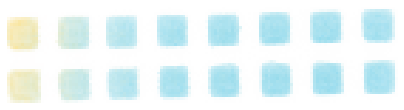

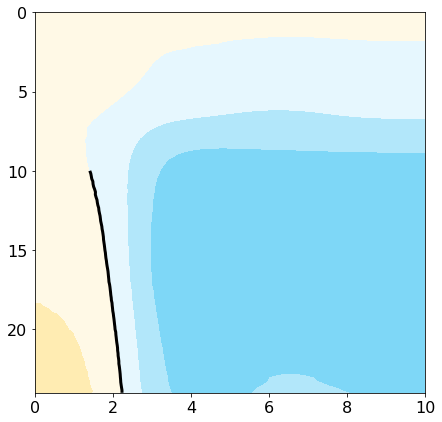

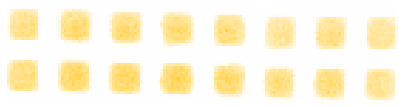

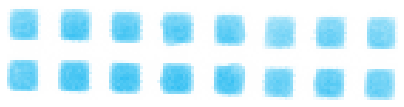

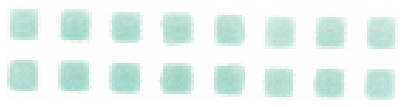

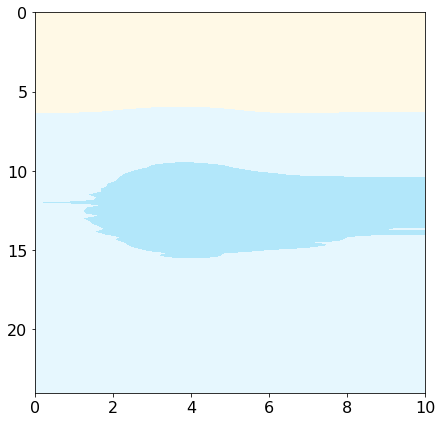

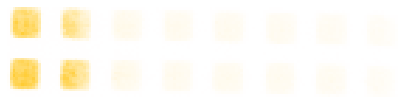

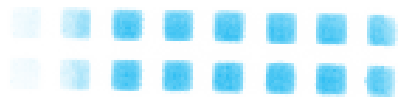

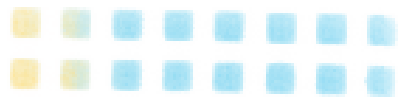

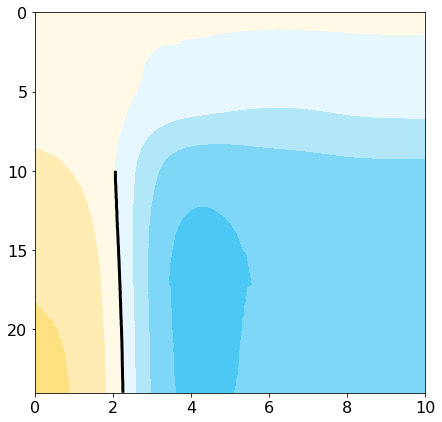

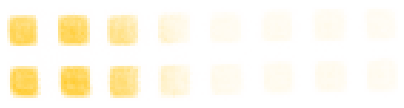

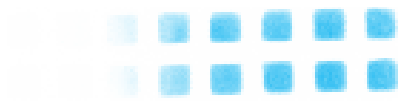

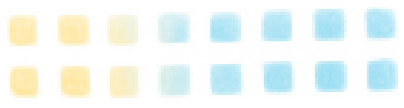

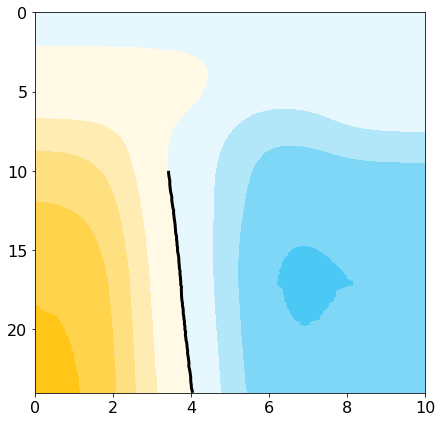

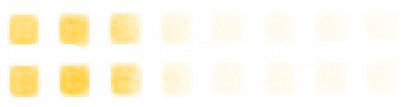

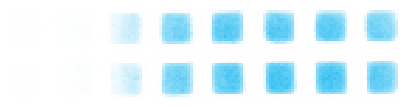

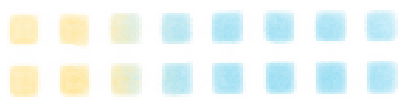

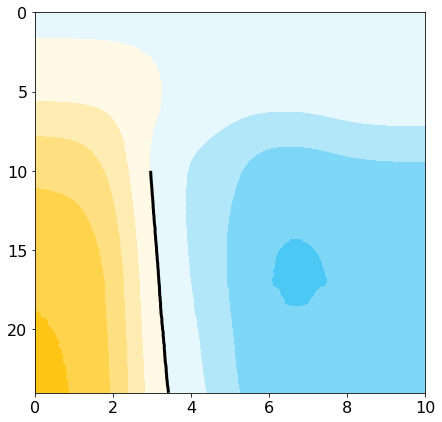

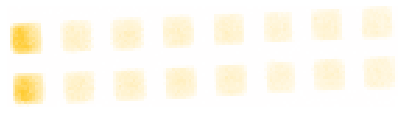

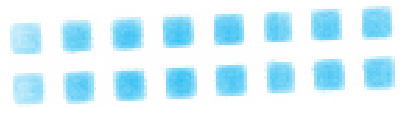

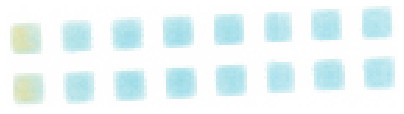

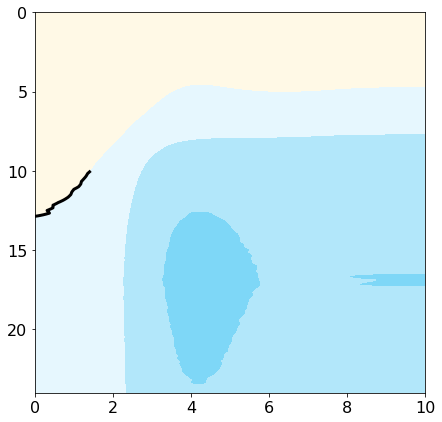

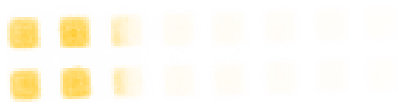

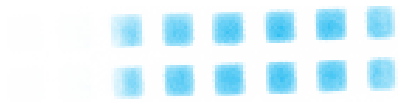

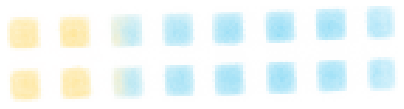

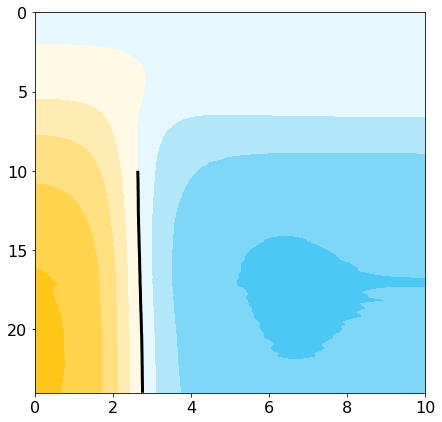

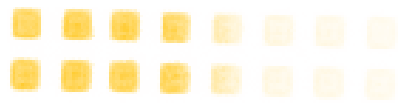

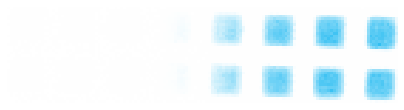

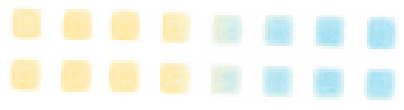

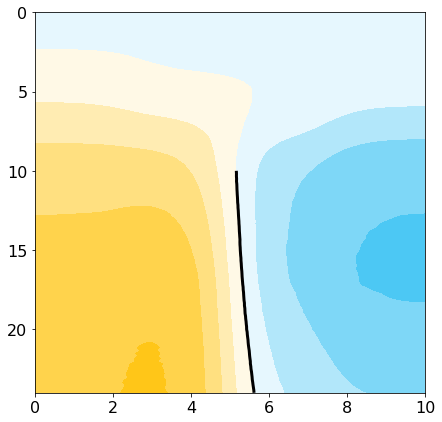

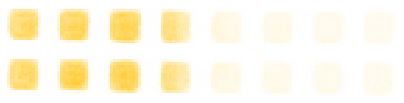

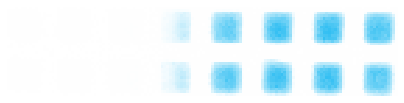

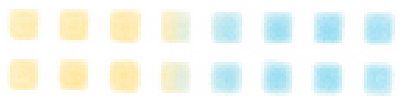

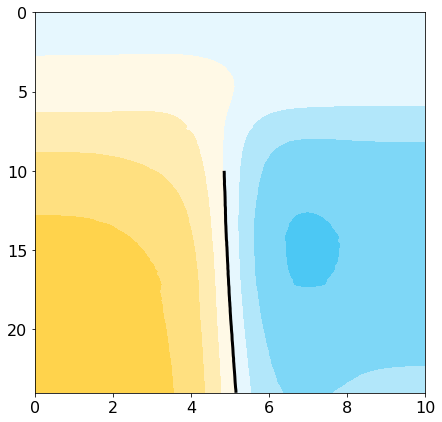

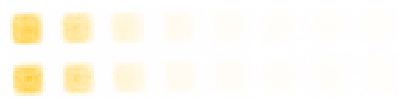

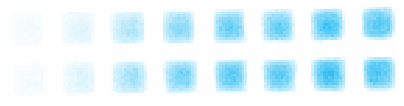

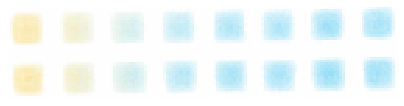

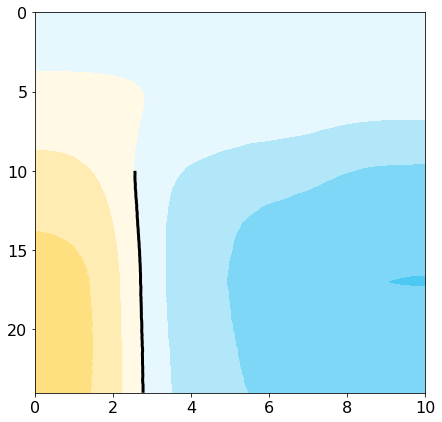

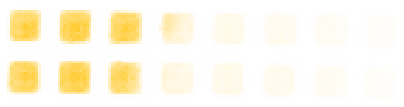

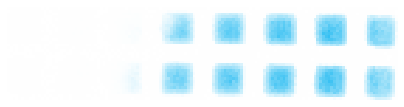

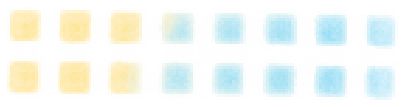

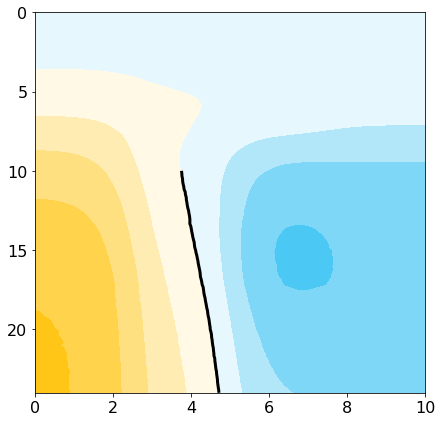

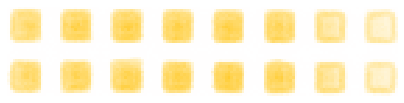

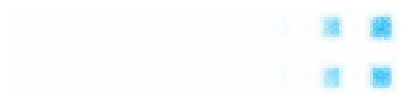

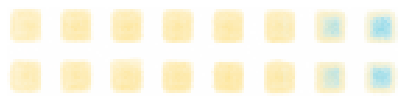

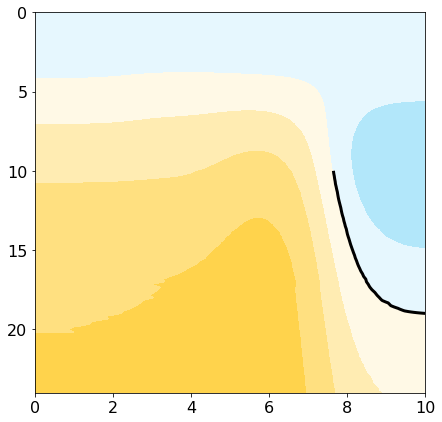

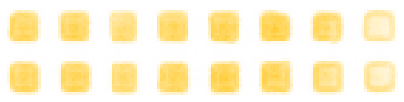

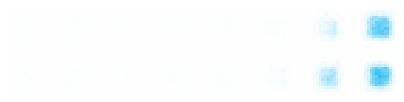

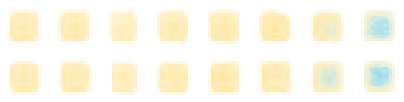

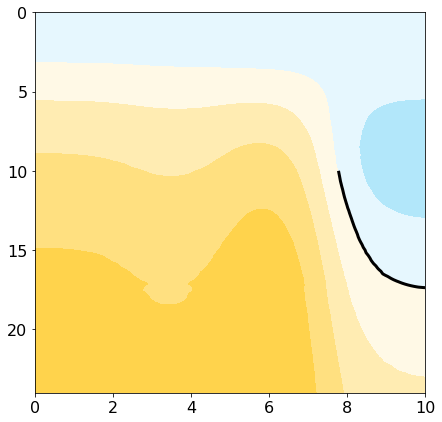

In [3]:
for region in regionprops(image_regions):
    if region.area >= 100:
        
        minr, minc, maxr, maxc = region.bbox
        hyperstack_region = hyperstack[:,minr:maxr,minc:maxc,:]
        
        figure(figsize=(7,7))
        #title('region label '+str(region.label))
        imshow(hyperstack_region[-1,:,:,yfp],cmap='yellow')
        axis('off')
        
        figure(figsize=(7,7))
        #title('region label '+str(region.label))
        imshow(hyperstack_region[-1,:,:,cfp],cmap='cyan')
        axis('off')
        
        figure(figsize=(7,7))
        #title('region label '+str(region.label))
        imshow(hyperstack_region[-1,:,:,yfp],cmap='yellow',alpha=0.5)
        imshow(hyperstack_region[-1,:,:,cfp],cmap='cyan',alpha=0.5)
        axis('off')
        
        data = hyperstack_region.astype(float)
        xx,tt,predictions,yfp_steady_state,cfp_steady_state = fit(data)

#         figure(figsize=(7,7))
#         title('steady state fit', fontsize=16, y=1.02)
#         plot(10*xx[0],data[-1,...,yfp].T,'.',color='#ffc000',alpha=0.1)
#         plot(10*xx[0],data[-1,...,cfp].T,'.',color='#00b0f0',alpha=0.1)

#         plot(10*xx[0],yfp_steady_state.predict(xx[0].reshape(-1,1)),color='#ffc000',linewidth=3)
#         plot(10*xx[0],cfp_steady_state.predict(xx[0].reshape(-1,1)),color='#00b0f0',linewidth=3)

#         xlabel('width, $x$ / cm',fontsize=16)
#         ylabel('arbitrary fluoresence units',fontsize=16)

        figure(figsize=(7,7))

        #contourf(10*xx,tt,,cmap='yellow',alpha=1)
        cs = contourf(10*xx,tt,predictions[...,1]-predictions[...,0],levels=linspace(-1,1,11),
                 cmap='cyanyellow',vmin=-1,vmax=1)
        #colorbar(cs)

        difference = predictions[...,0].T-predictions[...,1].T
        difference[(tt<10).T] = NaN
        contour(10*xx.T,tt.T,difference,levels=[0],colors=['black'],linewidths=[3])

#         xlabel('space (mm)',fontsize=24)
#         ylabel('time (hours)',fontsize=24)
        xticks(fontsize=16); yticks(fontsize=16)
        gca().invert_yaxis()
        
        boundary_index = argmin(abs(difference),axis=0)
        boundary_index = boundary_index[boundary_index>0]
        
#         if nanmin(abs(difference)) < 0.01 :
#             boundary = xx[0][boundary_index]

#             try :
#                 if boundary[-1] - boundary[0] > 0.09 :
#                     title('region '+str(region.label)+': moving right')
#                     region.label = 'moving right'
#                 elif boundary[-1] - boundary[0] < -0.09 :
#                     title('region '+str(region.label)+': moving left')
#                     region.label = 'moving left'
#                 else :
#                     title('region '+str(region.label)+': stationary')
#                     region.label = 'stationary'

#             except :
#                 title('region '+str(region.label)+': no boundary')
#                 region.label = 'no boundary'
#         else :
            
#             title('region '+str(region.label)+': no boundary')
#             region.label = 'no boundary'

In [ ]:
for region in regionprops(image_regions):
    if region.area >= 100:
        
        minr, minc, maxr, maxc = region.bbox
        hyperstack_region = hyperstack[:,minr:maxr,minc:maxc,:]
        
        figure(figsize=(7,7))
        #title('region label '+str(region.label))
        imshow(hyperstack_region[-1,:,:,yfp],cmap='yellow')
        axis('off')
        
        figure(figsize=(7,7))
        #title('region label '+str(region.label))
        imshow(hyperstack_region[-1,:,:,cfp],cmap='cyan')
        axis('off')
        
        figure(figsize=(7,7))
        #title('region label '+str(region.label))
        imshow(hyperstack_region[-1,:,:,yfp],cmap='yellow',alpha=0.5)
        imshow(hyperstack_region[-1,:,:,cfp],cmap='cyan',alpha=0.5)
        axis('off')
        
        data = hyperstack_region.astype(float)
        xx,tt,predictions,yfp_steady_state,cfp_steady_state = fit(data)

#         figure(figsize=(7,7))
#         title('steady state fit', fontsize=16, y=1.02)
#         plot(10*xx[0],data[-1,...,yfp].T,'.',color='#ffc000',alpha=0.1)
#         plot(10*xx[0],data[-1,...,cfp].T,'.',color='#00b0f0',alpha=0.1)

#         plot(10*xx[0],yfp_steady_state.predict(xx[0].reshape(-1,1)),color='#ffc000',linewidth=3)
#         plot(10*xx[0],cfp_steady_state.predict(xx[0].reshape(-1,1)),color='#00b0f0',linewidth=3)

#         xlabel('width, $x$ / cm',fontsize=16)
#         ylabel('arbitrary fluoresence units',fontsize=16)

        figure(figsize=(7,7))

        #contourf(10*xx,tt,,cmap='yellow',alpha=1)
        cs = contourf(10*xx,tt,predictions[...,1]-predictions[...,0],levels=linspace(-1,1,11),
                 cmap='cyanyellow',vmin=-1,vmax=1)
        #colorbar(cs)

        difference = predictions[...,0].T-predictions[...,1].T
        difference[(tt<10).T] = NaN
        contour(10*xx.T,tt.T,difference,levels=[0],colors=['black'],linewidths=[3])

#         xlabel('space (mm)',fontsize=24)
#         ylabel('time (hours)',fontsize=24)
        xticks(fontsize=16); yticks(fontsize=16)
        gca().invert_yaxis()
        
        boundary_index = argmin(abs(difference),axis=0)
        boundary_index = boundary_index[boundary_index>0]
        
#         if nanmin(abs(difference)) < 0.01 :
#             boundary = xx[0][boundary_index]

#             try :
#                 if boundary[-1] - boundary[0] > 0.09 :
#                     title('region '+str(region.label)+': moving right')
#                     region.label = 'moving right'
#                 elif boundary[-1] - boundary[0] < -0.09 :
#                     title('region '+str(region.label)+': moving left')
#                     region.label = 'moving left'
#                 else :
#                     title('region '+str(region.label)+': stationary')
#                     region.label = 'stationary'

#             except :
#                 title('region '+str(region.label)+': no boundary')
#                 region.label = 'no boundary'
#         else :
            
#             title('region '+str(region.label)+': no boundary')
#             region.label = 'no boundary'

In [ ]:
for region in regionprops(image_regions):
    if region.area >= 100:
        
        minr, minc, maxr, maxc = region.bbox
        hyperstack_region = hyperstack[:,minr:maxr,minc:maxc,:]
        
        figure(figsize=(7,7))
        #title('region label '+str(region.label))
        imshow(hyperstack_region[-1,:,:,yfp],cmap='yellow')
        axis('off')
        
        figure(figsize=(7,7))
        #title('region label '+str(region.label))
        imshow(hyperstack_region[-1,:,:,cfp],cmap='cyan')
        axis('off')
        
        figure(figsize=(7,7))
        #title('region label '+str(region.label))
        imshow(hyperstack_region[-1,:,:,yfp],cmap='yellow',alpha=0.5)
        imshow(hyperstack_region[-1,:,:,cfp],cmap='cyan',alpha=0.5)
        axis('off')
        
        data = hyperstack_region.astype(float)
        xx,tt,predictions,yfp_steady_state,cfp_steady_state = fit(data)

#         figure(figsize=(7,7))
#         title('steady state fit', fontsize=16, y=1.02)
#         plot(10*xx[0],data[-1,...,yfp].T,'.',color='#ffc000',alpha=0.1)
#         plot(10*xx[0],data[-1,...,cfp].T,'.',color='#00b0f0',alpha=0.1)

#         plot(10*xx[0],yfp_steady_state.predict(xx[0].reshape(-1,1)),color='#ffc000',linewidth=3)
#         plot(10*xx[0],cfp_steady_state.predict(xx[0].reshape(-1,1)),color='#00b0f0',linewidth=3)

#         xlabel('width, $x$ / cm',fontsize=16)
#         ylabel('arbitrary fluoresence units',fontsize=16)

        figure(figsize=(7,7))

        #contourf(10*xx,tt,,cmap='yellow',alpha=1)
        cs = contourf(10*xx,tt,predictions[...,1]-predictions[...,0],levels=linspace(-1,1,11),
                 cmap='cyanyellow',vmin=-1,vmax=1)
        #colorbar(cs)

        difference = predictions[...,0].T-predictions[...,1].T
        difference[(tt<10).T] = NaN
        contour(10*xx.T,tt.T,difference,levels=[0],colors=['black'],linewidths=[3])

#         xlabel('space (mm)',fontsize=24)
#         ylabel('time (hours)',fontsize=24)
        xticks(fontsize=16); yticks(fontsize=16)
        gca().invert_yaxis()
        
        boundary_index = argmin(abs(difference),axis=0)
        boundary_index = boundary_index[boundary_index>0]
        
#         if nanmin(abs(difference)) < 0.01 :
#             boundary = xx[0][boundary_index]

#             try :
#                 if boundary[-1] - boundary[0] > 0.09 :
#                     title('region '+str(region.label)+': moving right')
#                     region.label = 'moving right'
#                 elif boundary[-1] - boundary[0] < -0.09 :
#                     title('region '+str(region.label)+': moving left')
#                     region.label = 'moving left'
#                 else :
#                     title('region '+str(region.label)+': stationary')
#                     region.label = 'stationary'

#             except :
#                 title('region '+str(region.label)+': no boundary')
#                 region.label = 'no boundary'
#         else :
            
#             title('region '+str(region.label)+': no boundary')
#             region.label = 'no boundary'

In [ ]:
for region in regionprops(image_regions):
    if region.area >= 100:
        
        minr, minc, maxr, maxc = region.bbox
        hyperstack_region = hyperstack[:,minr:maxr,minc:maxc,:]
        
        figure(figsize=(7,7))
        #title('region label '+str(region.label))
        imshow(hyperstack_region[-1,:,:,yfp],cmap='yellow')
        axis('off')
        
        figure(figsize=(7,7))
        #title('region label '+str(region.label))
        imshow(hyperstack_region[-1,:,:,cfp],cmap='cyan')
        axis('off')
        
        figure(figsize=(7,7))
        #title('region label '+str(region.label))
        imshow(hyperstack_region[-1,:,:,yfp],cmap='yellow',alpha=0.5)
        imshow(hyperstack_region[-1,:,:,cfp],cmap='cyan',alpha=0.5)
        axis('off')
        
        data = hyperstack_region.astype(float)
        xx,tt,predictions,yfp_steady_state,cfp_steady_state = fit(data)

#         figure(figsize=(7,7))
#         title('steady state fit', fontsize=16, y=1.02)
#         plot(10*xx[0],data[-1,...,yfp].T,'.',color='#ffc000',alpha=0.1)
#         plot(10*xx[0],data[-1,...,cfp].T,'.',color='#00b0f0',alpha=0.1)

#         plot(10*xx[0],yfp_steady_state.predict(xx[0].reshape(-1,1)),color='#ffc000',linewidth=3)
#         plot(10*xx[0],cfp_steady_state.predict(xx[0].reshape(-1,1)),color='#00b0f0',linewidth=3)

#         xlabel('width, $x$ / cm',fontsize=16)
#         ylabel('arbitrary fluoresence units',fontsize=16)

        figure(figsize=(7,7))

        #contourf(10*xx,tt,,cmap='yellow',alpha=1)
        cs = contourf(10*xx,tt,predictions[...,1]-predictions[...,0],levels=linspace(-1,1,11),
                 cmap='cyanyellow',vmin=-1,vmax=1)
        #colorbar(cs)

        difference = predictions[...,0].T-predictions[...,1].T
        difference[(tt<10).T] = NaN
        contour(10*xx.T,tt.T,difference,levels=[0],colors=['black'],linewidths=[3])

#         xlabel('space (mm)',fontsize=24)
#         ylabel('time (hours)',fontsize=24)
        xticks(fontsize=16); yticks(fontsize=16)
        gca().invert_yaxis()
        
        boundary_index = argmin(abs(difference),axis=0)
        boundary_index = boundary_index[boundary_index>0]
        
#         if nanmin(abs(difference)) < 0.01 :
#             boundary = xx[0][boundary_index]

#             try :
#                 if boundary[-1] - boundary[0] > 0.09 :
#                     title('region '+str(region.label)+': moving right')
#                     region.label = 'moving right'
#                 elif boundary[-1] - boundary[0] < -0.09 :
#                     title('region '+str(region.label)+': moving left')
#                     region.label = 'moving left'
#                 else :
#                     title('region '+str(region.label)+': stationary')
#                     region.label = 'stationary'

#             except :
#                 title('region '+str(region.label)+': no boundary')
#                 region.label = 'no boundary'
#         else :
            
#             title('region '+str(region.label)+': no boundary')
#             region.label = 'no boundary'

In [ ]:
figure(figsize=(12,12))
imshow(hyperstack[-1,:,:,yfp],cmap='yellow')
imshow(hyperstack[-1,:,:,cfp],cmap='cyan')

for region in regionprops(image_regions):
    if region.area >= 100:
        
        minr, minc, maxr, maxc = region.bbox
        hyperstack_region = hyperstack[:,minr:maxr,minc:maxc,:]
        
        data = hyperstack_region.astype(float)
        xx,tt,predictions,yfp_steady_state,cfp_steady_state = fit(data)

        difference = predictions[...,0].T-predictions[...,1].T
        difference[(tt<10).T] = NaN
        
        boundary_index = argmin(abs(difference),axis=0)
        boundary_index = boundary_index[boundary_index>0]
        
        if nanmin(abs(difference)) < 0.01 :
            boundary = xx[0][boundary_index]

            try :
                if boundary[-1] - boundary[0] > 0.09 :
                    text(minc,minr,str(region.label)+ ' moving right')
                elif boundary[-1] - boundary[0] < -0.09 :
                    text(minc,minr,str(region.label)+ ' moving left')
                else :
                    text(minc,minr,str(region.label)+ ' stationary')
            except :
                text(minc,minr,str(region.label)+ ' no boundary')
                
        else :
            text(minc,minr,str(region.label)+ ' no boundary')